<a href="https://colab.research.google.com/github/yilinmiao/image_sft_dpo_experiment/blob/main/image_sft_dpo_no_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SECTION 1: Setup and Dependencies


Install dependencies and set up the environment

In [1]:
# !pip install torch torchvision numpy matplotlib pillow tqdm scikit-image lpips

In [2]:
# Import modules
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import random
import glob
from google.colab import drive
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
import lpips
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
# Create directories
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("dataset", exist_ok=True)

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



# SECTION 2: Create Synthetic Data


Create synthetic data for training and testing

In [5]:
# Create dataset directories
os.makedirs("dataset/input/train", exist_ok=True)
os.makedirs("dataset/input/val", exist_ok=True)
os.makedirs("dataset/input/test", exist_ok=True)
os.makedirs("dataset/input/train_pref", exist_ok=True)
os.makedirs("dataset/input/val_pref", exist_ok=True)

os.makedirs("dataset/target/train", exist_ok=True)
os.makedirs("dataset/target/val", exist_ok=True)
os.makedirs("dataset/target/test", exist_ok=True)

os.makedirs("dataset/preferred/train", exist_ok=True)
os.makedirs("dataset/preferred/val", exist_ok=True)
os.makedirs("dataset/dispreferred/train", exist_ok=True)
os.makedirs("dataset/dispreferred/val", exist_ok=True)

# Create synthetic data using CIFAR10
from torchvision.datasets import CIFAR10

# Download CIFAR10 dataset for demo purposes
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())


In [6]:
# Function to create synthetic data
def save_synthetic_data(dataset, num_samples, input_dir, target_dir, pref_dir=None, dispref_dir=None):
    indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(indices):
        img, _ = dataset[idx]

        # Save original image (scaled to our needs)
        img_pil = transforms.ToPILImage()(img)
        img_pil = img_pil.resize((256, 256), Image.BICUBIC)
        img_pil.save(f"{input_dir}/{i:04d}.png")

        # Create a synthetic "enhanced" version
        enhanced = TF.adjust_brightness(img, 1.2)  # Brighter
        enhanced = TF.adjust_contrast(enhanced, 1.5)  # More contrast
        enhanced = TF.adjust_saturation(enhanced, 1.3)  # More saturation

        enhanced_pil = transforms.ToPILImage()(enhanced)
        enhanced_pil = enhanced_pil.resize((256, 256), Image.BICUBIC)
        enhanced_pil.save(f"{target_dir}/{i:04d}.png")

        # For preference data
        if pref_dir and dispref_dir:
            # More enhanced version ("preferred")
            pref = TF.adjust_brightness(enhanced, 1.1)
            pref = TF.adjust_contrast(pref, 1.2)
            pref_pil = transforms.ToPILImage()(pref)
            pref_pil = pref_pil.resize((256, 256), Image.BICUBIC)
            pref_pil.save(f"{pref_dir}/{i:04d}.png")

            # Less enhanced version ("dispreferred")
            dispref = TF.adjust_brightness(img, 0.9)
            dispref = TF.adjust_contrast(dispref, 0.8)
            dispref_pil = transforms.ToPILImage()(dispref)
            dispref_pil = dispref_pil.resize((256, 256), Image.BICUBIC)
            dispref_pil.save(f"{dispref_dir}/{i:04d}.png")

In [7]:
# Create training data
save_synthetic_data(train_dataset, 50, "dataset/input/train", "dataset/target/train")
save_synthetic_data(train_dataset, 20, "dataset/input/val", "dataset/target/val")
save_synthetic_data(test_dataset, 20, "dataset/input/test", "dataset/target/test")

# Create preference data
save_synthetic_data(train_dataset, 30, "dataset/input/train_pref", "dataset/target/train",
                    "dataset/preferred/train", "dataset/dispreferred/train")
save_synthetic_data(test_dataset, 10, "dataset/input/val_pref", "dataset/target/val",
                    "dataset/preferred/val", "dataset/dispreferred/val")


In [8]:
print(f"Created synthetic data for demonstration:")
print(f"- Training pairs: {len(glob.glob('dataset/input/train/*.png'))}")
print(f"- Validation pairs: {len(glob.glob('dataset/input/val/*.png'))}")
print(f"- Test pairs: {len(glob.glob('dataset/input/test/*.png'))}")
print(f"- Preference training samples: {len(glob.glob('dataset/input/train_pref/*.png'))}")
print(f"- Preference validation samples: {len(glob.glob('dataset/input/val_pref/*.png'))}")

Created synthetic data for demonstration:
- Training pairs: 50
- Validation pairs: 20
- Test pairs: 20
- Preference training samples: 30
- Preference validation samples: 10


# SECTION 3: Model Implementation

Define the model architecture and datasets

In [9]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# For visualization (unnormalized)
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)

In [10]:
class EnhancementModel(nn.Module):
    def __init__(self):
        super(EnhancementModel, self).__init__()

        # Encoder blocks with padding to ensure divisible dimensions
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        # Decoder blocks with upsampling
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Sequential(
            nn.Conv2d(1024 + 512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec4 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Final layer
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 1),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        # Encoder with pooling
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Print sizes for debugging
        print(f"Input size: {x.size()}")
        print(f"e1 size: {e1.size()}, e2 size: {e2.size()}")
        print(f"e3 size: {e3.size()}, e4 size: {e4.size()}")
        print(f"Bottleneck size: {b.size()}")

        # Decoder with skip connections and upsampling
        d1 = self.up1(b)
        # Ensure compatible sizes for concatenation
        if d1.size()[2:] != e4.size()[2:]:
            d1 = F.interpolate(d1, size=e4.size()[2:], mode='bilinear', align_corners=True)
        print(f"d1 size after up: {d1.size()}, e4 size: {e4.size()}")
        d1 = torch.cat([d1, e4], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        if d2.size()[2:] != e3.size()[2:]:
            d2 = F.interpolate(d2, size=e3.size()[2:], mode='bilinear', align_corners=True)
        print(f"d2 size after up: {d2.size()}, e3 size: {e3.size()}")
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)
        if d3.size()[2:] != e2.size()[2:]:
            d3 = F.interpolate(d3, size=e2.size()[2:], mode='bilinear', align_corners=True)
        print(f"d3 size after up: {d3.size()}, e2 size: {e2.size()}")
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.dec3(d3)

        d4 = self.up4(d3)
        if d4.size()[2:] != e1.size()[2:]:
            d4 = F.interpolate(d4, size=e1.size()[2:], mode='bilinear', align_corners=True)
        print(f"d4 size after up: {d4.size()}, e1 size: {e1.size()}")
        d4 = torch.cat([d4, e1], dim=1)
        d4 = self.dec4(d4)

        # Final
        output = self.final(d4)

        return output

In [11]:
# Define datasets
class ImageEnhancementDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_files = sorted(glob.glob(os.path.join(input_dir, "*.jpg")) +
                                 glob.glob(os.path.join(input_dir, "*.png")))
        self.target_files = sorted(glob.glob(os.path.join(target_dir, "*.jpg")) +
                                  glob.glob(os.path.join(target_dir, "*.png")))

        assert len(self.input_files) == len(self.target_files), "Input and target directories should have same number of images"

        self.transform = transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_img = Image.open(self.input_files[idx]).convert("RGB")
        target_img = Image.open(self.target_files[idx]).convert("RGB")

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return {"input": input_img, "target": target_img}

In [27]:
class PreferenceDataset(Dataset):
    """Dataset for DPO training with preference pairs"""

    def __init__(self, input_images, enhanced_w, enhanced_l, transform=None):
        self.input_images = input_images
        self.enhanced_w = enhanced_w
        self.enhanced_l = enhanced_l
        self.transform = transform

        assert len(input_images) == len(enhanced_w) == len(enhanced_l), "Input and preference image lists must have the same length"

        # Check if files exist
        for i, (inp, pref, dispref) in enumerate(zip(input_images[:5], enhanced_w[:5], enhanced_l[:5])):
            if not os.path.exists(inp):
                print(f"Warning: Input image {inp} does not exist")
            if not os.path.exists(pref):
                print(f"Warning: Preferred image {pref} does not exist")
            if not os.path.exists(dispref):
                print(f"Warning: Dispreferred image {dispref} does not exist")

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        try:
            input_img = Image.open(self.input_images[idx]).convert("RGB")
            preferred_img = Image.open(self.enhanced_w[idx]).convert("RGB")
            dispreferred_img = Image.open(self.enhanced_l[idx]).convert("RGB")

            if self.transform:
                input_img = self.transform(input_img)
                preferred_img = self.transform(preferred_img)
                dispreferred_img = self.transform(dispreferred_img)

            return {
                "input": input_img,
                "preferred": preferred_img,
                "dispreferred": dispreferred_img
            }
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            # Return a dummy sample that won't break the training loop
            dummy = torch.zeros(3, 256, 256)
            return {
                "input": dummy,
                "preferred": dummy,
                "dispreferred": dummy
            }

In [28]:
# Create datasets
train_dataset = ImageEnhancementDataset(
    input_dir="dataset/input/train",
    target_dir="dataset/target/train",
    transform=transform
)

val_dataset = ImageEnhancementDataset(
    input_dir="dataset/input/val",
    target_dir="dataset/target/val",
    transform=transform
)

test_dataset = ImageEnhancementDataset(
    input_dir="dataset/input/test",
    target_dir="dataset/target/test",
    transform=transform
)


In [29]:
# Create preference datasets for DPO
train_pref_dataset = PreferenceDataset(
    input_images=sorted(glob.glob("dataset/input/train_pref/*.png")),
    enhanced_w=sorted(glob.glob("dataset/preferred/train/*.png")),
    enhanced_l=sorted(glob.glob("dataset/dispreferred/train/*.png")),
    transform=transform
)

val_pref_dataset = PreferenceDataset(
    input_images=sorted(glob.glob("dataset/input/val_pref/*.png")),
    enhanced_w=sorted(glob.glob("dataset/preferred/val/*.png")),
    enhanced_l=sorted(glob.glob("dataset/dispreferred/val/*.png")),
    transform=transform
)

In [30]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

train_pref_loader = DataLoader(train_pref_dataset, batch_size=4, shuffle=True, num_workers=2)
val_pref_loader = DataLoader(val_pref_dataset, batch_size=4, shuffle=False, num_workers=2)

preferences_loader = {
    "train": train_pref_loader,
    "val": val_pref_loader
}

In [31]:
class DPOLoss(nn.Module):
    """
    Direct Preference Optimization loss for image enhancement
    """
    def __init__(self, beta=0.1):
        super(DPOLoss, self).__init__()
        self.beta = beta
        # Perceptual loss for image quality assessment
        self.perceptual_loss = lpips.LPIPS(net='alex').to(device)

    def forward(self, policy_output_w, policy_output_l, reference_output_w, reference_output_l):
        """
        Calculate DPO loss based on preferred (w) and dispreferred (l) outputs
        """
        try:
            # Calculate perceptual distances
            pi_logp_w = -self.perceptual_loss(policy_output_w, reference_output_w).mean()
            pi_logp_l = -self.perceptual_loss(policy_output_l, reference_output_l).mean()
            ref_logp_w = -self.perceptual_loss(reference_output_w, reference_output_w).mean()
            ref_logp_l = -self.perceptual_loss(reference_output_l, reference_output_l).mean()

            # Print debug info
            print(f"Perceptual distances - pi_w: {pi_logp_w.item():.4f}, pi_l: {pi_logp_l.item():.4f}, ref_w: {ref_logp_w.item():.4f}, ref_l: {ref_logp_l.item():.4f}")

            # Calculate DPO loss
            logits = self.beta * ((pi_logp_w - ref_logp_w) - (pi_logp_l - ref_logp_l))
            loss = -F.logsigmoid(logits)

            # Use a smaller epsilon for numerical stability
            if torch.isnan(loss) or torch.isinf(loss):
                print("Warning: NaN or Inf in DPO loss, using epsilon stabilization")
                logits = self.beta * ((pi_logp_w - ref_logp_w + 1e-6) - (pi_logp_l - ref_logp_l + 1e-6))
                loss = -F.logsigmoid(logits + 1e-6)

            return loss

        except Exception as e:
            print(f"Error in DPO loss: {e}")
            # Return a default loss that can be backpropagated
            return torch.tensor(1.0, requires_grad=True, device=device)

In [32]:
# Initialize models
sft_model = EnhancementModel().to(device)
dpo_model = EnhancementModel().to(device)
combined_model = EnhancementModel().to(device)

print("Model and datasets initialized successfully!")

Model and datasets initialized successfully!


# SECTION 4: Training Functions

Define training and evaluation functions

In [33]:
# Define training functions
def train_sft_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Combined loss: L1 + perceptual
    l1_loss = nn.L1Loss()
    perceptual_loss = lpips.LPIPS(net='alex').to(device)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs = batch["input"].to(device)
            targets = batch["target"].to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate losses
            l1 = l1_loss(outputs, targets)
            perceptual = perceptual_loss(outputs, targets).mean()

            # Combined loss
            loss = l1 + 0.1 * perceptual

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs = batch["input"].to(device)
                targets = batch["target"].to(device)

                outputs = model(inputs)

                # Calculate losses
                l1 = l1_loss(outputs, targets)
                perceptual = perceptual_loss(outputs, targets).mean()

                # Combined loss
                loss = l1 + 0.1 * perceptual

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'models/sft_best_model.pth')
            print("New best model saved!")

        # Save sample results
        if (epoch + 1) % 2 == 0:
            save_sample_results(model, val_loader, epoch, prefix="sft")

    print("SFT training completed!")
    return model

In [34]:
def train_dpo_model(policy_model, reference_model, train_loader, val_loader, num_epochs=5, lr=0.0001):
    """
    Train model using Direct Preference Optimization

    Args:
        policy_model: Model being optimized
        reference_model: Frozen reference model (usually SFT model)
        train_loader: DataLoader with preference pairs
        val_loader: Validation DataLoader
        num_epochs: Number of training epochs
        lr: Learning rate
    """
    # Freeze reference model
    for param in reference_model.parameters():
        param.requires_grad = False
    reference_model.eval()

    # Setup for policy model training
    optimizer = optim.Adam(policy_model.parameters(), lr=lr)
    dpo_loss_fn = DPOLoss(beta=0.1)

    best_val_loss = float('inf')

    # Check for valid dataloaders
    try:
        print(f"Train dataloader length: {len(train_loader)}")
        print(f"Val dataloader length: {len(val_loader)}")

        # Check a batch
        sample_batch = next(iter(train_loader))
        print(f"Sample batch keys: {sample_batch.keys()}")
        print(f"Input shape: {sample_batch['input'].shape}")
        print(f"Preferred shape: {sample_batch['preferred'].shape}")
        print(f"Dispreferred shape: {sample_batch['dispreferred'].shape}")
    except Exception as e:
        print(f"Error checking dataloaders: {e}")
        return policy_model

    for epoch in range(num_epochs):
        # Training
        policy_model.train()
        train_loss = 0.0

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - DPO Training")):
            try:
                inputs = batch["input"].to(device)
                preferred = batch["preferred"].to(device)
                dispreferred = batch["dispreferred"].to(device)

                # Get outputs from policy model
                policy_output_w = policy_model(inputs)
                policy_output_l = policy_model(inputs)  # Same input, but will be compared to different targets

                # Get outputs from reference model (frozen)
                with torch.no_grad():
                    reference_output_w = reference_model(inputs)
                    reference_output_l = reference_model(inputs)

                # Calculate DPO loss
                loss = dpo_loss_fn(policy_output_w, policy_output_l, reference_output_w, reference_output_l)

                # Add L1 regularization to keep close to reference model outputs
                l1_reg_w = F.l1_loss(policy_output_w, preferred)
                l1_reg_l = F.l1_loss(policy_output_l, dispreferred)

                # Combined loss with regularization
                combined_loss = loss + 0.1 * (l1_reg_w + l1_reg_l)

                # Backward and optimize
                optimizer.zero_grad()
                combined_loss.backward()
                optimizer.step()

                train_loss += combined_loss.item()

                # Print debug info for first few batches
                if batch_idx < 2:
                    print(f"Batch {batch_idx} - Loss: {combined_loss.item():.4f}, DPO: {loss.item():.4f}, L1_w: {l1_reg_w.item():.4f}, L1_l: {l1_reg_l.item():.4f}")

            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue

        if len(train_loader) > 0:
            avg_train_loss = train_loss / len(train_loader)
        else:
            avg_train_loss = 0
            print("Warning: Train loader has zero length")

        # Validation
        policy_model.eval()
        val_loss = 0.0
        val_batches = 0

        try:
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - DPO Validation"):
                    inputs = batch["input"].to(device)
                    preferred = batch["preferred"].to(device)
                    dispreferred = batch["dispreferred"].to(device)

                    # Get outputs
                    policy_output_w = policy_model(inputs)
                    policy_output_l = policy_model(inputs)
                    reference_output_w = reference_model(inputs)
                    reference_output_l = reference_model(inputs)

                    # Calculate loss
                    loss = dpo_loss_fn(policy_output_w, policy_output_l, reference_output_w, reference_output_l)

                    # Add regularization
                    l1_reg_w = F.l1_loss(policy_output_w, preferred)
                    l1_reg_l = F.l1_loss(policy_output_l, dispreferred)
                    combined_loss = loss + 0.1 * (l1_reg_w + l1_reg_l)

                    val_loss += combined_loss.item()
                    val_batches += 1
        except Exception as e:
            print(f"Error during validation: {e}")

        if val_batches > 0:
            avg_val_loss = val_loss / val_batches
        else:
            avg_val_loss = 0
            print("Warning: No validation batches completed")

        print(f"Epoch {epoch+1}/{num_epochs}, DPO Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(policy_model.state_dict(), 'models/dpo_best_model.pth')
            print("New best DPO model saved!")

        # Save sample results
        if (epoch + 1) % 1 == 0:
            try:
                save_sample_results(policy_model, val_loader, epoch, prefix="dpo")
            except Exception as e:
                print(f"Error saving sample results: {e}")

    print("DPO training completed!")
    return policy_model

In [35]:
def train_combined_model(model, train_loader, val_loader, preferences_loader, num_epochs=10, sft_epochs=5, dpo_epochs=5):
    # First stage: SFT training
    print("Starting SFT training phase...")
    model = train_sft_model(model, train_loader, val_loader, num_epochs=sft_epochs)

    # Save SFT model as reference model for DPO
    torch.save(model.state_dict(), 'models/sft_reference_model.pth')

    # Create a copy for DPO training
    reference_model = EnhancementModel().to(device)
    reference_model.load_state_dict(model.state_dict())

    # Create a new policy model initialized from SFT model
    policy_model = EnhancementModel().to(device)
    policy_model.load_state_dict(model.state_dict())

    # Second stage: DPO training
    print("Starting DPO training phase...")
    policy_model = train_dpo_model(policy_model, reference_model,
                                  preferences_loader["train"], preferences_loader["val"],
                                  num_epochs=dpo_epochs)

    # Save final combined model
    torch.save(policy_model.state_dict(), 'models/sft_dpo_combined_model.pth')
    print("Combined SFT+DPO training completed!")

    return policy_model

In [41]:
def calculate_metrics(original_img, generated_img, target_img):
    """Calculate image quality metrics with error handling"""

    # Convert tensors to numpy arrays
    if isinstance(original_img, torch.Tensor):
        original_img = inv_normalize(original_img).cpu().numpy().transpose(1, 2, 0)
        original_img = np.clip(original_img, 0, 1)

    if isinstance(generated_img, torch.Tensor):
        generated_img = inv_normalize(generated_img).cpu().numpy().transpose(1, 2, 0)
        generated_img = np.clip(generated_img, 0, 1)

    if isinstance(target_img, torch.Tensor):
        target_img = inv_normalize(target_img).cpu().numpy().transpose(1, 2, 0)
        target_img = np.clip(target_img, 0, 1)

    # Check image dimensions
    min_dim = min(min(target_img.shape[0:2]), min(generated_img.shape[0:2]))
    print(f"Image dimensions - Target: {target_img.shape}, Generated: {generated_img.shape}")

    # Calculate PSNR between generated and target
    try:
        psnr_value = psnr(target_img, generated_img)
    except Exception as e:
        print(f"Error calculating PSNR: {e}")
        psnr_value = 0.0

    # Calculate SSIM between generated and target with adaptive window size
    try:
        # Choose a window size that's odd and smaller than the minimum dimension
        win_size = min(7, min_dim - (min_dim % 2 == 0))  # Make sure it's odd
        if win_size < 3:
            win_size = 3  # Minimum window size for SSIM

        # Ensure the window size is valid
        if win_size % 2 == 0:
            win_size -= 1

        print(f"Using SSIM window size: {win_size}")
        ssim_value = ssim(
            target_img,
            generated_img,
            win_size=win_size,
            channel_axis=2,  # Explicitly specify the channel axis
            data_range=1.0   # Explicitly specify the data range
        )
    except Exception as e:
        print(f"Error calculating SSIM: {e}")
        ssim_value = 0.0

    return {
        "psnr": psnr_value,
        "ssim": ssim_value
    }

In [42]:
def save_sample_results(model, dataloader, epoch, prefix="", num_samples=4):
    model.eval()
    batch = next(iter(dataloader))
    inputs = batch["input"].to(device)[:num_samples]
    targets = batch["target"][:num_samples]

    with torch.no_grad():
        outputs = model(inputs)

    # Create a grid of images: input, output, target
    images = []
    for i in range(num_samples):
        img_input = inv_normalize(inputs[i].cpu())
        img_output = inv_normalize(outputs[i].cpu())
        img_target = targets[i].cpu()

        images.extend([img_input, img_output, img_target])

    grid = make_grid(images, nrow=3, normalize=False)
    utils.save_image(grid, f"results/{prefix}_results_epoch_{epoch+1}.png")

In [43]:
def compare_models(test_loader, sft_model, dpo_model, combined_model, num_samples=6):
    """Compare results from different models with error handling"""
    try:
        sft_model.eval()
        dpo_model.eval()
        combined_model.eval()

        batch = next(iter(test_loader))
        inputs = batch["input"].to(device)[:num_samples]
        targets = batch["target"][:num_samples]

        with torch.no_grad():
            sft_outputs = sft_model(inputs)
            dpo_outputs = dpo_model(inputs)
            combined_outputs = combined_model(inputs)

        # Create a grid: input, SFT output, DPO output, combined output, target
        images = []
        metrics = {
            "sft": {"psnr": 0, "ssim": 0},
            "dpo": {"psnr": 0, "ssim": 0},
            "combined": {"psnr": 0, "ssim": 0}
        }

        for i in range(num_samples):
            print(f"\nProcessing sample {i+1}/{num_samples}")

            img_input = inv_normalize(inputs[i].cpu())
            img_sft = inv_normalize(sft_outputs[i].cpu())
            img_dpo = inv_normalize(dpo_outputs[i].cpu())
            img_combined = inv_normalize(combined_outputs[i].cpu())
            img_target = targets[i].cpu()

            # Calculate metrics with error handling
            try:
                print(f"Calculating metrics for SFT model")
                sft_metrics = calculate_metrics(img_input, img_sft, img_target)

                print(f"Calculating metrics for DPO model")
                dpo_metrics = calculate_metrics(img_input, img_dpo, img_target)

                print(f"Calculating metrics for Combined model")
                combined_metrics = calculate_metrics(img_input, img_combined, img_target)

                # Accumulate metrics
                for key in metrics["sft"]:
                    metrics["sft"][key] += sft_metrics[key]
                    metrics["dpo"][key] += dpo_metrics[key]
                    metrics["combined"][key] += combined_metrics[key]
            except Exception as e:
                print(f"Error calculating metrics for sample {i}: {e}")

            # Add images to grid regardless of metric calculation
            images.extend([img_input, img_sft, img_dpo, img_combined, img_target])

        # Average metrics
        for model_type in metrics:
            for metric in metrics[model_type]:
                metrics[model_type][metric] /= num_samples

        # Print metrics
        print("\nAverage metrics:")
        print(f"SFT model - PSNR: {metrics['sft']['psnr']:.2f}, SSIM: {metrics['sft']['ssim']:.4f}")
        print(f"DPO model - PSNR: {metrics['dpo']['psnr']:.2f}, SSIM: {metrics['dpo']['ssim']:.4f}")
        print(f"Combined model - PSNR: {metrics['combined']['psnr']:.2f}, SSIM: {metrics['combined']['ssim']:.4f}")

        # Create and save grid
        print("Creating image grid...")
        grid = make_grid(images, nrow=5, normalize=False)
        utils.save_image(grid, "results/model_comparison.png")

        # Create a visualization with titles
        plt.figure(figsize=(20, 4 * num_samples))
        np_grid = grid.numpy().transpose(1, 2, 0)

        plt.imshow(np_grid)
        plt.title("Comparison: Input | SFT | DPO | Combined | Target", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig("results/model_comparison_with_titles.png")
        plt.close()

        from IPython.display import Image, display
        display(Image('results/model_comparison_with_titles.png'))

        print("Model comparison completed successfully!")

    except Exception as e:
        print(f"Error in compare_models: {e}")
        import traceback
        traceback.print_exc()

# SECTION 5: Model Training

Train the models

In [44]:
# Train SFT model
print("Training SFT model...")
# For demonstration, we use fewer epochs
sft_model = train_sft_model(sft_model, train_loader, val_loader, num_epochs=3, lr=0.001)

# Create reference model from SFT for DPO training
reference_model = EnhancementModel().to(device)
reference_model.load_state_dict(sft_model.state_dict())

# Train DPO model from scratch
print("Training DPO model...")
# For demonstration, we use fewer epochs
dpo_model = train_dpo_model(dpo_model, reference_model, train_pref_loader, val_pref_loader, num_epochs=2, lr=0.0001)

# Train combined SFT+DPO model
print("Training combined SFT+DPO model...")
# For demonstration, we use fewer epochs
combined_model = train_combined_model(combined_model, train_loader, val_loader, preferences_loader,
                                     sft_epochs=2, dpo_epochs=2)

Training SFT model...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Epoch 1/3 - Training:   0%|          | 0/7 [00:00<?, ?it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])


Epoch 1/3 - Training:  14%|█▍        | 1/7 [00:00<00:01,  4.48it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

Epoch 1/3 - Training:  43%|████▎     | 3/7 [00:00<00:00,  8.03it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])


Epoch 1/3 - Training:  71%|███████▏  | 5/7 [00:00<00:00,  9.68it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

Epoch 1/3 - Training: 100%|██████████| 7/7 [00:00<00:00, 11.86it/s]

Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2, 256, 64, 64])
d3 size after up: torch.Size([2, 256, 128, 128]), e2 size: torch.Size([2, 128, 128, 128])
d4 size after up: torch.Size([2, 128, 256, 256]), e1 size: torch.Size([2, 64, 256, 256])


Epoch 1/3 - Validation: 100%|██████████| 3/3 [00:00<00:00, 11.83it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

New best model saved!


Epoch 2/3 - Training:   0%|          | 0/7 [00:00<?, ?it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])


Epoch 2/3 - Training:  14%|█▍        | 1/7 [00:00<00:01,  4.62it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

Epoch 2/3 - Training:  43%|████▎     | 3/7 [00:00<00:00,  8.47it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])


Epoch 2/3 - Training:  71%|███████▏  | 5/7 [00:00<00:00, 10.02it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

Epoch 2/3 - Training: 100%|██████████| 7/7 [00:00<00:00, 12.17it/s]

Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2, 256, 64, 64])
d3 size after up: torch.Size([2, 256, 128, 128]), e2 size: torch.Size([2, 128, 128, 128])
d4 size after up: torch.Size([2, 128, 256, 256]), e1 size: torch.Size([2, 64, 256, 256])


Epoch 2/3 - Validation: 100%|██████████| 3/3 [00:00<00:00, 11.70it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

New best model saved!
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])


Epoch 3/3 - Training:  14%|█▍        | 1/7 [00:00<00:01,  4.50it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

Epoch 3/3 - Training:  71%|███████▏  | 5/7 [00:00<00:00,  9.95it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

Epoch 3/3 - Training: 100%|██████████| 7/7 [00:00<00:00,  9.93it/s]


Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2, 256, 64, 64])
d3 size after up: torch.Size([2, 256, 128, 128]), e2 size: torch.Size([2, 128, 128, 128])
d4 size after up: torch.Size([2, 128, 256, 256]), e1 size: torch.Size([2, 64, 256, 256])


Epoch 3/3 - Validation: 100%|██████████| 3/3 [00:00<00:00, 12.03it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

New best model saved!
SFT training completed!
Training DPO model...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Train dataloader length: 8
Val dataloader length: 3
Sample batch keys: dict_keys(['input', 'preferred', 'dispreferred'])
Input shape: torch.Size([4, 3, 256, 256])
Preferred shape: torch.Size([4, 3, 256, 256])
Dispreferred shape: torch.Size([4, 3, 256, 256])


Epoch 1/2 - DPO Training:   0%|          | 0/8 [00:00<?, ?it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 1/2 - DPO Training:  12%|█▎        | 1/8 [00:00<00:01,  3.83it/s]

Batch 0 - Loss: 0.7521, DPO: 0.6931, L1_w: 0.3665, L1_l: 0.2226
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size

Epoch 1/2 - DPO Training:  25%|██▌       | 2/8 [00:00<00:01,  5.26it/s]

Perceptual distances - pi_w: -0.5825, pi_l: -0.5825, ref_w: -0.0000, ref_l: -0.0000
Batch 1 - Loss: 0.7658, DPO: 0.6931, L1_w: 0.3892, L1_l: 0.3373
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size af

Epoch 1/2 - DPO Training:  38%|███▊      | 3/8 [00:00<00:00,  6.31it/s]

Perceptual distances - pi_w: -0.5227, pi_l: -0.5227, ref_w: -0.0000, ref_l: -0.0000
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])


Epoch 1/2 - DPO Training:  50%|█████     | 4/8 [00:00<00:00,  6.97it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 1/2 - DPO Training:  62%|██████▎   | 5/8 [00:00<00:00,  7.42it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 1/2 - DPO Training:  75%|███████▌  | 6/8 [00:00<00:00,  7.72it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 1/2 - DPO Training:  88%|████████▊ | 7/8 [00:01<00:00,  7.90it/s]

Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2, 256, 64, 64])
d3 size after up: torch.Size([2, 256, 128, 128]), e2 size: torch.Size([2, 128, 128, 128])
d4 size after up: torch.Size([2, 128, 256, 256]), e1 size: torch.Size([2, 64, 256, 256])
Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2,

Epoch 1/2 - DPO Validation: 100%|██████████| 3/3 [00:00<00:00,  9.77it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

New best DPO model saved!
Error saving sample results: 'target'


Epoch 2/2 - DPO Training:   0%|          | 0/8 [00:00<?, ?it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 2/2 - DPO Training:  12%|█▎        | 1/8 [00:00<00:01,  4.17it/s]

Batch 0 - Loss: 0.7417, DPO: 0.6931, L1_w: 0.3000, L1_l: 0.1859
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size

Epoch 2/2 - DPO Training:  25%|██▌       | 2/8 [00:00<00:01,  5.89it/s]

Batch 1 - Loss: 0.7457, DPO: 0.6931, L1_w: 0.3807, L1_l: 0.1444
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size

Epoch 2/2 - DPO Training:  38%|███▊      | 3/8 [00:00<00:00,  6.78it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 2/2 - DPO Training:  50%|█████     | 4/8 [00:00<00:00,  7.30it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 2/2 - DPO Training:  62%|██████▎   | 5/8 [00:00<00:00,  7.65it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 2/2 - DPO Training:  75%|███████▌  | 6/8 [00:00<00:00,  7.89it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 2/2 - DPO Training:  88%|████████▊ | 7/8 [00:00<00:00,  8.00it/s]

Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2, 256, 64, 64])
d3 size after up: torch.Size([2, 256, 128, 128]), e2 size: torch.Size([2, 128, 128, 128])
d4 size after up: torch.Size([2, 128, 256, 256]), e1 size: torch.Size([2, 64, 256, 256])
Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2,

Epoch 2/2 - DPO Validation: 100%|██████████| 3/3 [00:00<00:00,  9.79it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Error saving sample results: 'target'
DPO training completed!
Training combined SFT+DPO model...
Starting SFT training phase...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Epoch 1/2 - Training:   0%|          | 0/7 [00:00<?, ?it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])


Epoch 1/2 - Training:  14%|█▍        | 1/7 [00:00<00:01,  4.65it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

Epoch 1/2 - Training:  43%|████▎     | 3/7 [00:00<00:00,  8.49it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])


Epoch 1/2 - Training:  71%|███████▏  | 5/7 [00:00<00:00, 10.02it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

Epoch 1/2 - Training: 100%|██████████| 7/7 [00:00<00:00, 12.20it/s]

Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2, 256, 64, 64])
d3 size after up: torch.Size([2, 256, 128, 128]), e2 size: torch.Size([2, 128, 128, 128])
d4 size after up: torch.Size([2, 128, 256, 256]), e1 size: torch.Size([2, 64, 256, 256])


Epoch 1/2 - Validation: 100%|██████████| 3/3 [00:00<00:00, 12.00it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

New best model saved!


Epoch 2/2 - Training:   0%|          | 0/7 [00:00<?, ?it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])


Epoch 2/2 - Training:  14%|█▍        | 1/7 [00:00<00:01,  4.64it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

Epoch 2/2 - Training:  43%|████▎     | 3/7 [00:00<00:00,  8.50it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])


Epoch 2/2 - Training:  71%|███████▏  | 5/7 [00:00<00:00, 10.03it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

Epoch 2/2 - Training: 100%|██████████| 7/7 [00:00<00:00, 12.18it/s]

Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2, 256, 64, 64])
d3 size after up: torch.Size([2, 256, 128, 128]), e2 size: torch.Size([2, 128, 128, 128])
d4 size after up: torch.Size([2, 128, 256, 256]), e1 size: torch.Size([2, 64, 256, 256])


Epoch 2/2 - Validation: 100%|██████████| 3/3 [00:00<00:00, 11.96it/s]

Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8, 256, 64, 64])
d3 size after up: torch.Size([8, 256, 128, 128]), e2 size: torch.Size([8, 128, 128, 128])
d4 size after up: torch.Size([8, 128, 256, 256]), e1 size: torch.Size([8, 64, 256, 256])
Input size: torch.Size([8, 3, 256, 256])
e1 size: torch.Size([8, 64, 256, 256]), e2 size: torch.Size([8, 128, 128, 128])
e3 size: torch.Size([8, 256, 64, 64]), e4 size: torch.Size([8, 512, 32, 32])
Bottleneck size: torch.Size([8, 1024, 16, 16])
d1 size after up: torch.Size([8, 1024, 32, 32]), e4 size: torch.Size([8, 512, 32, 32])
d2 size after up: torch.Size([8, 512, 64, 64]), e3 size: torch.Size([8,

New best model saved!
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
SFT training completed!
Starting DPO training phase...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Train dataloader length: 8
Val dataloader length: 3
Sample batch keys: dict_keys(['input', 'preferred', 'dispreferred'])
Input shape: torch.Size([4, 3, 256, 256])
Pre

Epoch 1/2 - DPO Training:   0%|          | 0/8 [00:00<?, ?it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 1/2 - DPO Training:  12%|█▎        | 1/8 [00:00<00:01,  3.94it/s]

Batch 0 - Loss: 0.7608, DPO: 0.6931, L1_w: 0.2992, L1_l: 0.3772
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size

Epoch 1/2 - DPO Training:  25%|██▌       | 2/8 [00:00<00:01,  5.34it/s]

Perceptual distances - pi_w: -0.5563, pi_l: -0.5563, ref_w: -0.0000, ref_l: -0.0000
Batch 1 - Loss: 0.7480, DPO: 0.6931, L1_w: 0.3158, L1_l: 0.2329
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size af

Epoch 1/2 - DPO Training:  38%|███▊      | 3/8 [00:00<00:00,  6.37it/s]

Perceptual distances - pi_w: -0.6500, pi_l: -0.6500, ref_w: -0.0000, ref_l: -0.0000
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])


Epoch 1/2 - DPO Training:  50%|█████     | 4/8 [00:00<00:00,  7.02it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 1/2 - DPO Training:  62%|██████▎   | 5/8 [00:00<00:00,  7.46it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 1/2 - DPO Training:  75%|███████▌  | 6/8 [00:00<00:00,  7.74it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 1/2 - DPO Training:  88%|████████▊ | 7/8 [00:00<00:00,  7.94it/s]

Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2, 256, 64, 64])
d3 size after up: torch.Size([2, 256, 128, 128]), e2 size: torch.Size([2, 128, 128, 128])
d4 size after up: torch.Size([2, 128, 256, 256]), e1 size: torch.Size([2, 64, 256, 256])
Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2,

Epoch 1/2 - DPO Validation: 100%|██████████| 3/3 [00:00<00:00, 10.02it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

New best DPO model saved!
Error saving sample results: 'target'


Epoch 2/2 - DPO Training:   0%|          | 0/8 [00:00<?, ?it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 2/2 - DPO Training:  12%|█▎        | 1/8 [00:00<00:01,  4.33it/s]

Batch 0 - Loss: 0.7402, DPO: 0.6931, L1_w: 0.3218, L1_l: 0.1489
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size

Epoch 2/2 - DPO Training:  25%|██▌       | 2/8 [00:00<00:00,  6.01it/s]

Batch 1 - Loss: 0.7411, DPO: 0.6931, L1_w: 0.2261, L1_l: 0.2532
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size

Epoch 2/2 - DPO Training:  38%|███▊      | 3/8 [00:00<00:00,  6.88it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 2/2 - DPO Training:  50%|█████     | 4/8 [00:00<00:00,  7.38it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 2/2 - DPO Training:  62%|██████▎   | 5/8 [00:00<00:00,  7.70it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 2/2 - DPO Training:  75%|███████▌  | 6/8 [00:00<00:00,  7.91it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

Epoch 2/2 - DPO Training:  88%|████████▊ | 7/8 [00:00<00:00,  8.04it/s]

Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2, 256, 64, 64])
d3 size after up: torch.Size([2, 256, 128, 128]), e2 size: torch.Size([2, 128, 128, 128])
d4 size after up: torch.Size([2, 128, 256, 256]), e1 size: torch.Size([2, 64, 256, 256])
Input size: torch.Size([2, 3, 256, 256])
e1 size: torch.Size([2, 64, 256, 256]), e2 size: torch.Size([2, 128, 128, 128])
e3 size: torch.Size([2, 256, 64, 64]), e4 size: torch.Size([2, 512, 32, 32])
Bottleneck size: torch.Size([2, 1024, 16, 16])
d1 size after up: torch.Size([2, 1024, 32, 32]), e4 size: torch.Size([2, 512, 32, 32])
d2 size after up: torch.Size([2, 512, 64, 64]), e3 size: torch.Size([2,

Epoch 2/2 - DPO Validation: 100%|██████████| 3/3 [00:00<00:00,  9.71it/s]

Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4,

New best DPO model saved!
Error saving sample results: 'target'
DPO training completed!
Combined SFT+DPO training completed!


# SECTION 6: Evaluate and Compare Models

Evaluate and compare the models

Comparing models...
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 size: torch.Size([4, 256, 64, 64])
d3 size after up: torch.Size([4, 256, 128, 128]), e2 size: torch.Size([4, 128, 128, 128])
d4 size after up: torch.Size([4, 128, 256, 256]), e1 size: torch.Size([4, 64, 256, 256])
Input size: torch.Size([4, 3, 256, 256])
e1 size: torch.Size([4, 64, 256, 256]), e2 size: torch.Size([4, 128, 128, 128])
e3 size: torch.Size([4, 256, 64, 64]), e4 size: torch.Size([4, 512, 32, 32])
Bottleneck size: torch.Size([4, 1024, 16, 16])
d1 size after up: torch.Size([4, 1024, 32, 32]), e4 size: torch.Size([4, 512, 32, 32])
d2 size after up: torch.Size([4, 512, 64, 64]), e3 

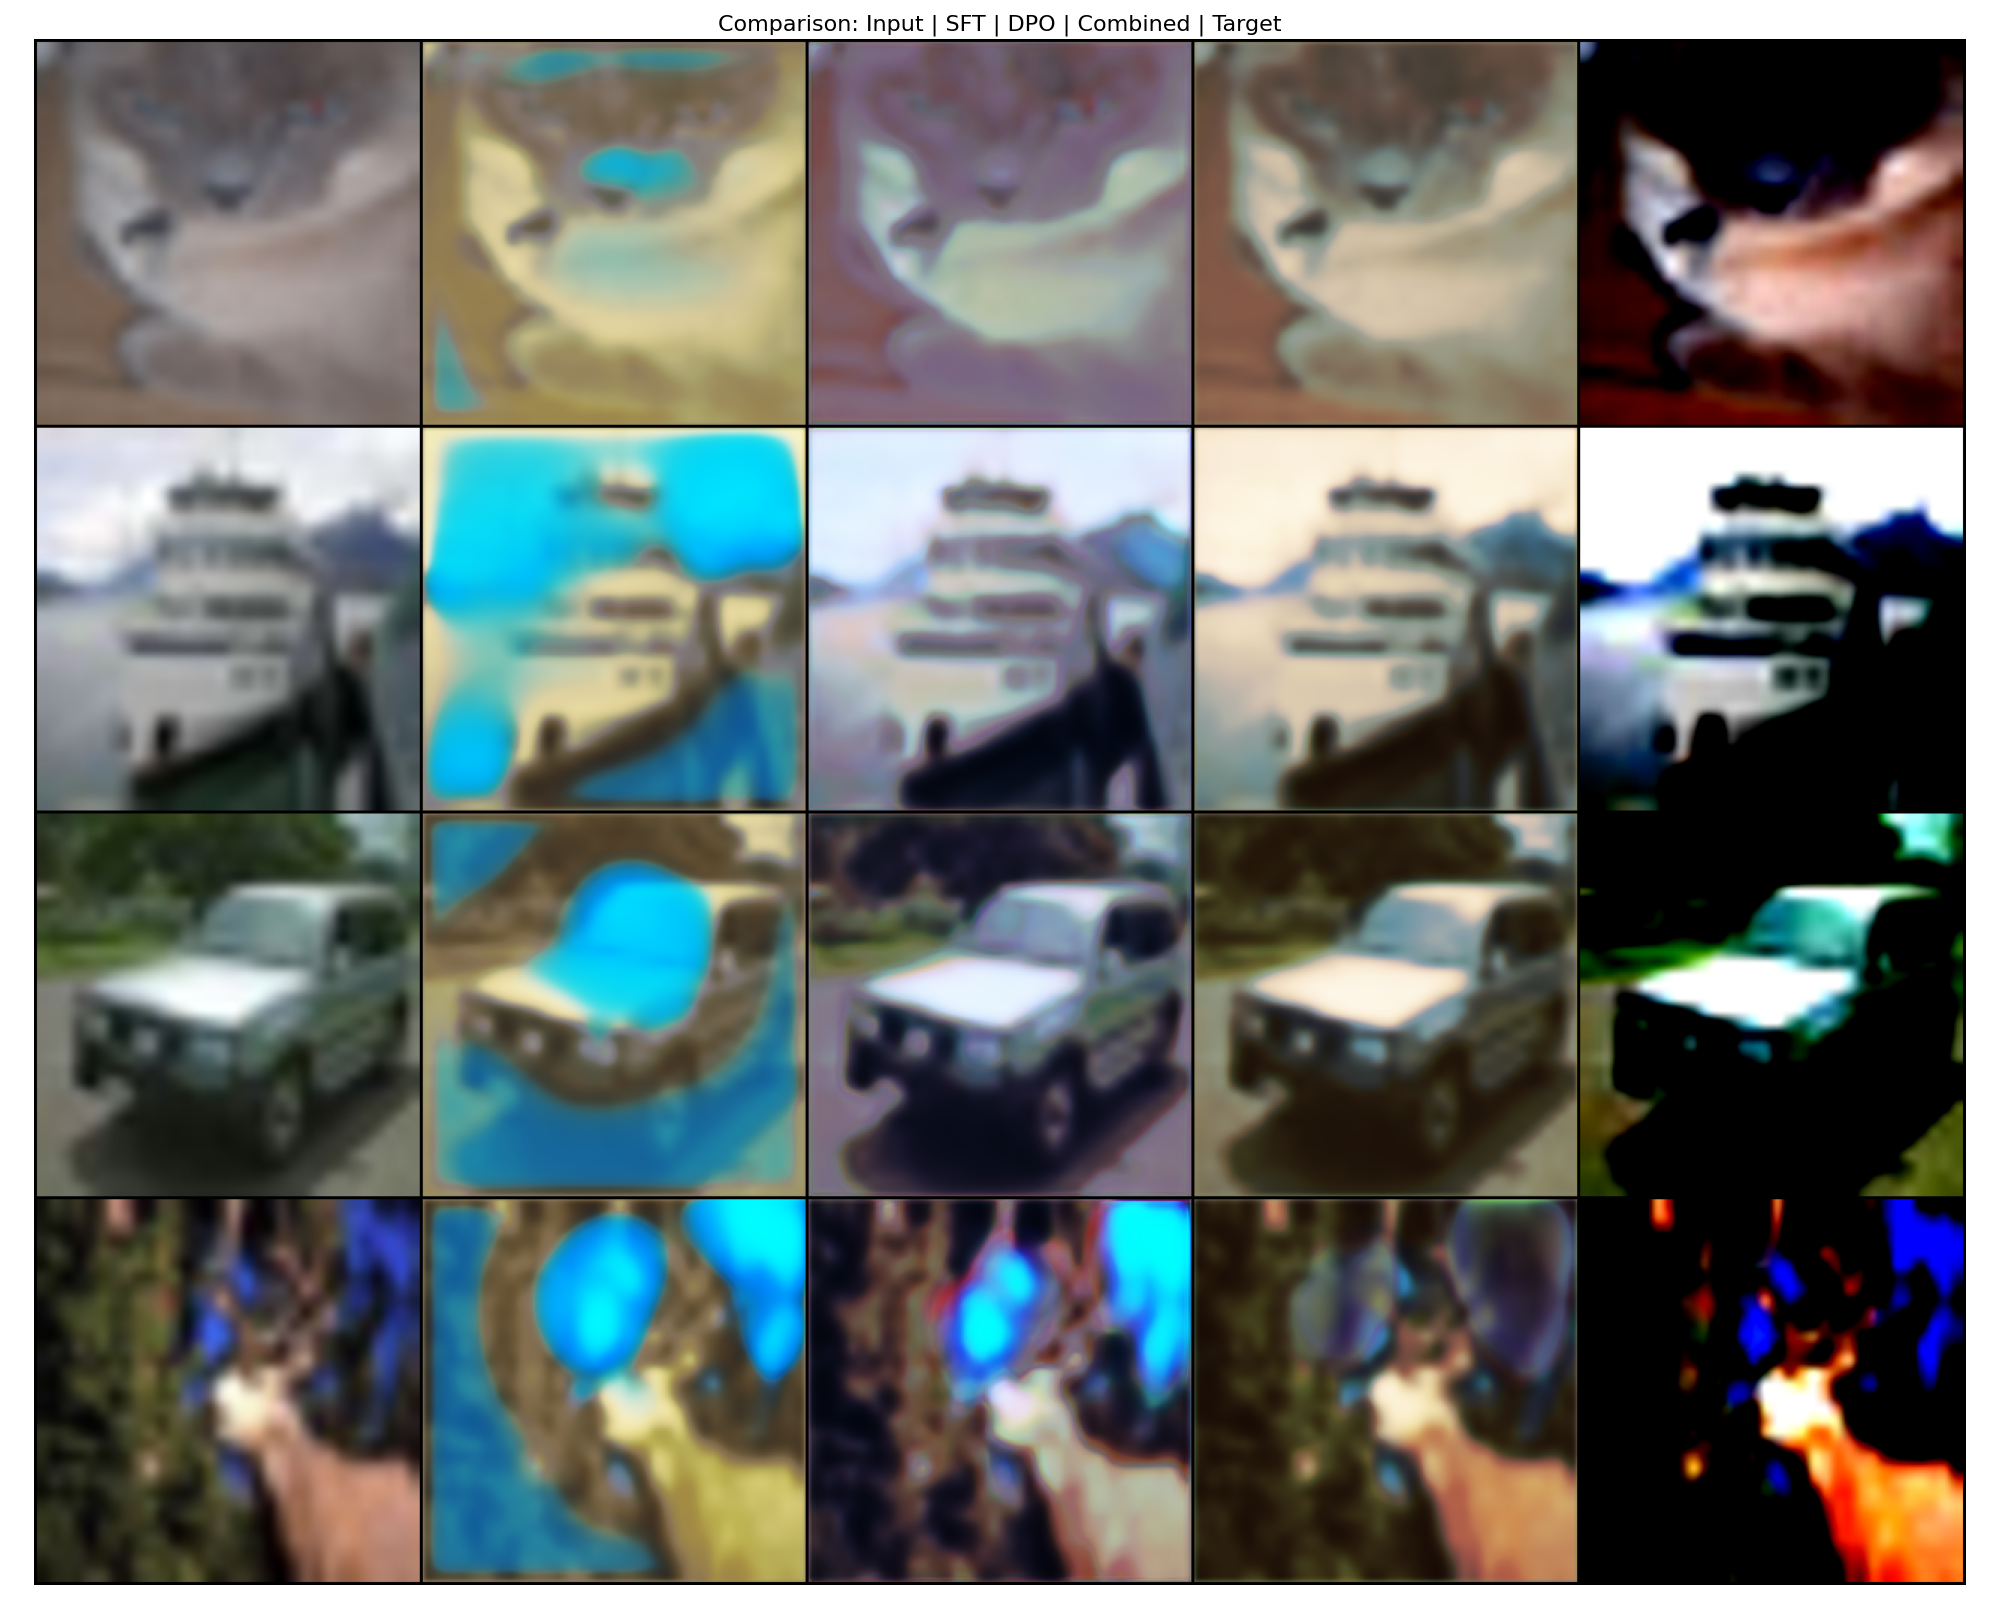

Model comparison completed successfully!
Results and models saved to Google Drive at: /content/drive/MyDrive/sft_dpo_results


In [45]:
# Visualize sample results from each model
print("Comparing models...")
compare_models(test_loader, sft_model, dpo_model, combined_model, num_samples=4)

# Save results to Google Drive
drive_path = "/content/drive/MyDrive/sft_dpo_results"
os.makedirs(drive_path, exist_ok=True)

# Copy result images
!cp -r results/* "{drive_path}/"

# Copy model weights
!cp -r models/* "{drive_path}/"

print(f"Results and models saved to Google Drive at: {drive_path}")

# SECTION 7: Inference with Saved Models

Load saved models and run inference on new images

In [46]:
def enhance_image(model, image_path, output_path):
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Run inference
    model.eval()
    with torch.no_grad():
        enhanced = model(img_tensor)

    # Convert to image and save
    enhanced = inv_normalize(enhanced[0].cpu())
    utils.save_image(enhanced, output_path)

    # Display original and enhanced
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced.permute(1, 2, 0).numpy())
    plt.title("Enhanced Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Saving monalisa.png to monalisa.png
Input size: torch.Size([1, 3, 256, 256])
e1 size: torch.Size([1, 64, 256, 256]), e2 size: torch.Size([1, 128, 128, 128])
e3 size: torch.Size([1, 256, 64, 64]), e4 size: torch.Size([1, 512, 32, 32])
Bottleneck size: torch.Size([1, 1024, 16, 16])
d1 size after up: torch.Size([1, 1024, 32, 32]), e4 size: torch.Size([1, 512, 32, 32])
d2 size after up: torch.Size([1, 512, 64, 64]), e3 size: torch.Size([1, 256, 64, 64])
d3 size after up: torch.Size([1, 256, 128, 128]), e2 size: torch.Size([1, 128, 128, 128])
d4 size after up: torch.Size([1, 128, 256, 256]), e1 size: torch.Size([1, 64, 256, 256])


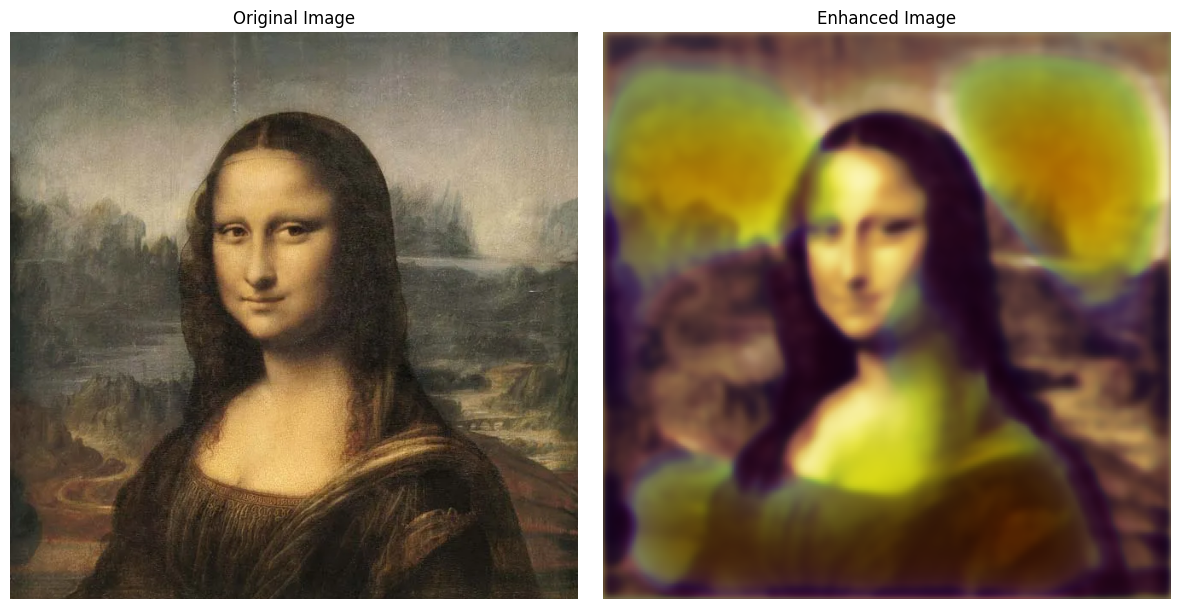

Input size: torch.Size([1, 3, 256, 256])
e1 size: torch.Size([1, 64, 256, 256]), e2 size: torch.Size([1, 128, 128, 128])
e3 size: torch.Size([1, 256, 64, 64]), e4 size: torch.Size([1, 512, 32, 32])
Bottleneck size: torch.Size([1, 1024, 16, 16])
d1 size after up: torch.Size([1, 1024, 32, 32]), e4 size: torch.Size([1, 512, 32, 32])
d2 size after up: torch.Size([1, 512, 64, 64]), e3 size: torch.Size([1, 256, 64, 64])
d3 size after up: torch.Size([1, 256, 128, 128]), e2 size: torch.Size([1, 128, 128, 128])
d4 size after up: torch.Size([1, 128, 256, 256]), e1 size: torch.Size([1, 64, 256, 256])


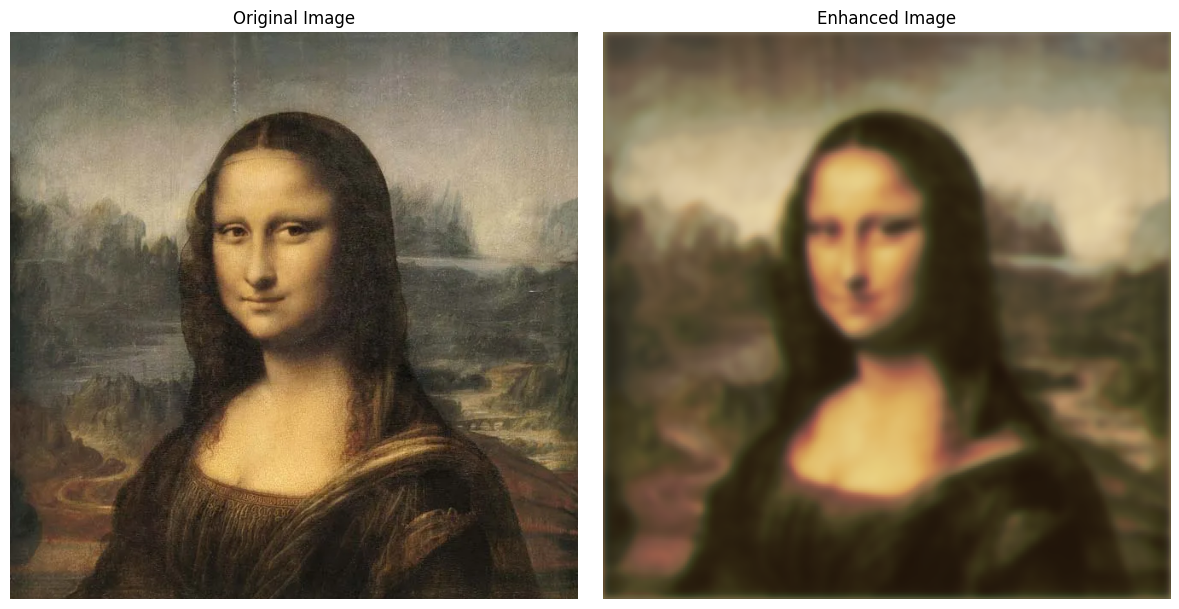

Input size: torch.Size([1, 3, 256, 256])
e1 size: torch.Size([1, 64, 256, 256]), e2 size: torch.Size([1, 128, 128, 128])
e3 size: torch.Size([1, 256, 64, 64]), e4 size: torch.Size([1, 512, 32, 32])
Bottleneck size: torch.Size([1, 1024, 16, 16])
d1 size after up: torch.Size([1, 1024, 32, 32]), e4 size: torch.Size([1, 512, 32, 32])
d2 size after up: torch.Size([1, 512, 64, 64]), e3 size: torch.Size([1, 256, 64, 64])
d3 size after up: torch.Size([1, 256, 128, 128]), e2 size: torch.Size([1, 128, 128, 128])
d4 size after up: torch.Size([1, 128, 256, 256]), e1 size: torch.Size([1, 64, 256, 256])


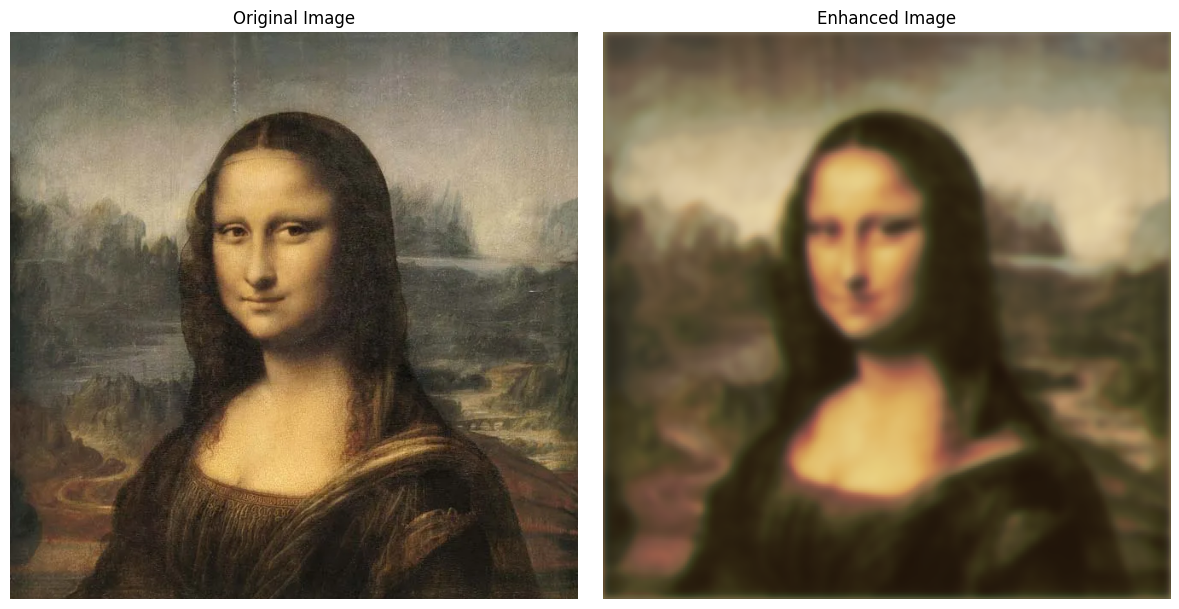

In [48]:

# Example usage with a new image
# Upload a new image
from google.colab import files
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]

# Load the saved models
sft_model.load_state_dict(torch.load('models/sft_best_model.pth'))
dpo_model.load_state_dict(torch.load('models/dpo_best_model.pth'))
combined_model.load_state_dict(torch.load('models/sft_dpo_combined_model.pth'))

# Enhance with all models
enhance_image(sft_model, filename, 'sft_enhanced.png')
enhance_image(dpo_model, filename, 'dpo_enhanced.png')
enhance_image(combined_model, filename, 'combined_enhanced.png')